In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate


Matplotlib created a temporary config/cache directory at /jobfs/119646119.gadi-pbs/matplotlib-pzk4p6wk because the default path (/home/563/ab2313/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.


In [2]:
from scipy.stats import gaussian_kde

In [3]:
import scipy.stats as stats

In [4]:
from matplotlib import rcParams

In [5]:
import sys, os
# My imports
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts'))
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts', 'src'))

In [6]:
import matplotlib.pylab as pylab
params = {'xtick.labelsize' : 'x-large', 'xtick.major.size':6}
pylab.rcParams.update(params)


In [7]:
std = 0.4

# Guassian

In [8]:
# def gaussian(x, mean, std):
#     return np.exp(-0.5 * ((x - mean) / std) ** 2) / (std * np.sqrt(2 * np.pi))


def skew_gaussian(x, mean, std, skewness):
    # Adjust the skewness parameter for the skew normal distribution
    return stats.skewnorm.pdf(x, skewness, loc=mean, scale=std)


def gaussian(x, mean, std):
    # Adjust the skewness parameter for the skew normal distribution
    return stats.norm.pdf(x, loc=mean, scale=std)

In [9]:
# def adjust_scale_for_variance(std, skewness):
#     delta = skewness / np.sqrt(1 + skewness ** 2)
#     adjusted_std = std / np.sqrt(1 - (2 * delta ** 2) / np.pi)
#     return adjusted_std

def adjust_scale_for_variance(std, skewness):
    delta = skewness / np.sqrt(1 + skewness ** 2)
    adjusted_std = std / np.sqrt(1 - (2 * delta ** 2) / np.pi)
    return adjusted_std

In [10]:
def caculate_distribution_overlap(dist1, dist2, x):
    # Calculate the overlap shape by taking the minimum of the two KDEs at each point
    overlap_shape = np.min(np.vstack([dist1, dist2]), axis=0)
    
    # Integrate the overlap shape to find the overlap area
    overlap_area = np.trapz(overlap_shape, x)
    
    # Convert the overlap area to a percentage
    overlap_percent = overlap_area * 100

    return overlap_percent

In [11]:
def stats_test_1d_array(arr, stats_func, window: int=20, base_period_length:int = 50):
    """
    Apply stats_func test along a 1D array.

    Parameters:
        arr (ArrayLike): 1D array to apply the test to.
        window (int): Size of the rolling window for the test.
        base_period_length (int, optional): Length of the base period. Defaults to 50.

    Returns:
        ArrayLike: Array of p-values.
    """
    # The data to use for the base period
    base_list = arr[:base_period_length]
    # Stop when there are not enough points left
    number_iterations = arr.shape[0] - window
    pval_array = np.zeros(number_iterations)
    
    for t in np.arange(number_iterations):
        arr_subset = arr[t: t+window]
        p_value = stats_func(base_list, arr_subset) # return_ttest_pvalue
        pval_array[t] = p_value

    # TODO: This could be done in the apply_ufunc
    lenghth_diff = arr.shape[0] - pval_array.shape[0]
    pval_array = np.append(pval_array, np.array([np.nan] *lenghth_diff))
    return pval_array 

def return_statistical_pvalue(arr1, arr2, stats_test):
    """
    Calculate the p-value for a given statistical test for two arrays.

    Parameters:
    arr1 (numpy array): The first input array.
    arr2 (numpy array): The second input array.

    Returns:
    float: The p-value of the specified statistical test.

    Notes:
    If either array contains only NaN values, the function returns NaN.
    """
    # Check if all values are nan
    #if np.all(np.isnan(arr1)) or np.all(np.isnan(arr2)): return np.nan
    #arr1, ar2 = remove_nans(arr1, arr2)

    return stats_test(arr1, arr2).pvalue

from functools import partial
from scipy.stats import anderson_ksamp, ks_2samp
return_ks_pvalue = partial(return_statistical_pvalue, stats_test=ks_2samp)


In [12]:
def fit_series(x, series):
    # x = np.arange(len(series))
    return  np.polyval(np.polyfit(x, series, deg=7), x)

In [13]:
def fit_two_series(s1, s2):
    series = np.concatenate([s1, s2])
    x = np.arange(len(series))
    return  np.polyval(np.polyfit(x, series, deg=4), x)

In [14]:
x2 = np.linspace(-1.5, 1.5, 100)
mean2 = 0.2
std = 0.2
skewness = -3

adjusted_std  = adjust_scale_for_variance(std, skewness)

In [15]:
# dist1 = gaussian(x2, 0, std)
# dist2 = gaussian(x2, 0.4, std)
dist1 = skew_gaussian(x2, 0, std, 1)
dist2 = skew_gaussian(x2, mean2, std, 1)
skew_dist = skew_gaussian(x2, mean2, adjusted_std, skewness)

In [16]:
skew_dist2 = np.zeros_like(skew_dist)
clip_val = 11
# skew_dist2[:-clip_val] = skew_dist[clip_val:]
skew_dist2[clip_val:] = skew_dist[:-clip_val]

In [17]:
integrate.simpson(x2 * skew_dist2, x2), integrate.simpson(x2 * dist2, x2)

(0.3016707661637631, 0.31283791659320015)

In [18]:
overlap = np.nanmin(np.array([dist1, dist2]).transpose(), axis=1)
overlap_skew = np.nanmin(np.array([dist1, skew_dist]).transpose(), axis=1)

In [19]:
caculate_distribution_overlap(dist1, dist2, x2), caculate_distribution_overlap(dist1, skew_dist2, x2)

(54.217861210356155, 55.16229722912467)

In [20]:
# plt.plot(skew_dist_aligned)
# plt.plot(dist2)

In [21]:
# Define the number of time steps
num_time_steps = 100

In [22]:
# Normalize the distribution to create a probability distribution
prob_dist1 = dist1 / np.sum(dist1)
# Generate a time series by sampling from the distribution
time_series1 = np.random.choice(x2, size=num_time_steps, p=prob_dist1)

In [23]:
# Find the indices of the 10 largest elements
time_series2 = time_series1.copy()
num_events = 20
largest_indices = np.argpartition(time_series2, -num_events)[-num_events:]

# Increase the values of these elements (multiply by 1.5)
time_series3 = time_series2.copy()
time_series4 = time_series2.copy()
time_series5 = time_series2.copy()

time_series3[largest_indices] += 0.1
time_series4[largest_indices] += 0.35
time_series5[largest_indices] += 0.45


In [24]:
# shuffled = np.random.choice(time_series1, size=100, replace=False)
# time_series2 = shuffled.copy(deep=True)
# time_series2[50:] = time_series2[50:] + 0.2

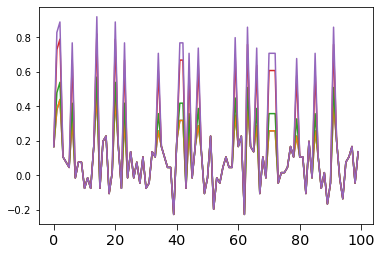

In [25]:
plt.plot(time_series1)
plt.plot(time_series2)
plt.plot(time_series3)
plt.plot(time_series4)
plt.plot(time_series5)

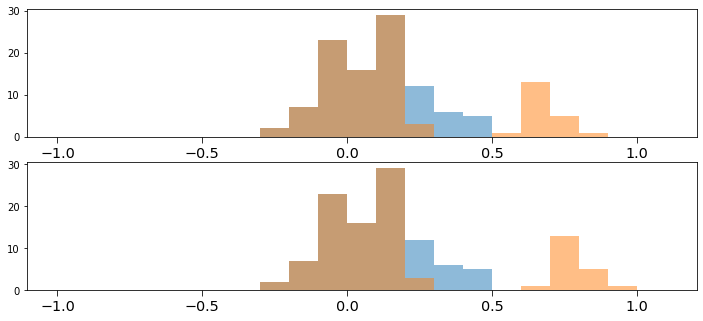

In [26]:
fig = plt.figure(figsize=(12, 8))

axes = [fig.add_subplot(3, 1, i+1) for i in range(2)]

bins = np.arange(-1, 1.2, .1)

# axes[0].hist(time_series1, alpha=0.5,bins=bins)
# plt.hist(time_series2, alpha=0.5)
# plt.hist(time_series3, alpha=0.5)

axes[0].hist(time_series1, alpha=0.5,bins=bins)
axes[1].hist(time_series1, alpha=0.5,bins=bins);

axes[0].hist(time_series4, alpha=0.5,bins=bins)
axes[1].hist(time_series5, alpha=0.5,bins=bins);


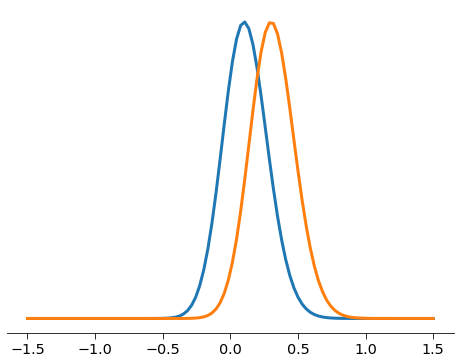

In [27]:
fig,ax = plt.subplots(figsize=(8, 6))
ax.plot(x2,dist1, linewidth=3)
ax.plot(x2,dist2, linewidth=3)
# ax.plot(x2,skew_dist2, linewidth=3)
# ax.fill_between(x2, [0] * len(overlap), overlap, color='grey')
# ax.fill_between(x2, [0] * len(overlap_skew), overlap_skew, color='black')


# Remove all spoines but x-axis
[ax.spines[spine].set_visible(False) for spine in ['top', 'left', 'right']]

ax.set_yticks([]);

In [28]:
# Normalize the distribution to create a probability distribution
prob_dist1 = dist1 / np.sum(dist1)
# Generate a time series by sampling from the distribution
time_series1 = np.random.choice(x2, size=num_time_steps, p=prob_dist1)

In [29]:
dist2 = skew_gaussian(x2, 0.3, std, 1)

In [30]:
# Normalize the distribution to create a probability distribution
prob_dist2 = dist2 / np.sum(dist2)
# Generate a time series by sampling from the distribution
time_series2 = np.random.choice(x2, size=num_time_steps, p=prob_dist2)

In [31]:
time_series3 = time_series2.copy()

In [32]:
# Find the indices of the three largest points in the time series
largest_indices = np.argpartition(time_series2, -3)[-3:]

# Increase the values of the three largest points by a desired factor (e.g., multiply by 1.5)
increase_factor = 1.5
time_series3[largest_indices] *= increase_factor

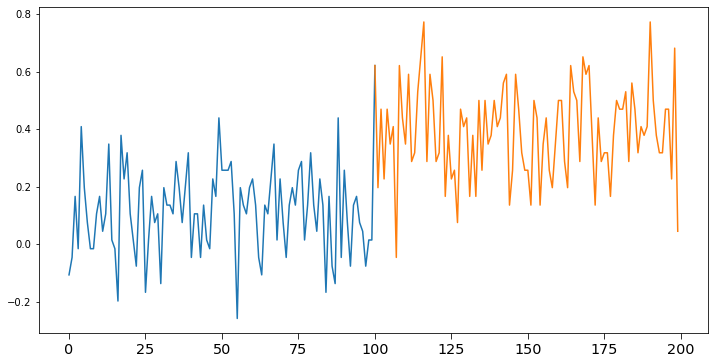

In [33]:
# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(time_series1)+1), time_series1.tolist()+ time_series2[:1].tolist())
plt.plot(np.arange(len(time_series1), len(time_series1)+len(time_series2)), time_series2)

(array([ 1.,  2., 11.,  9., 20., 18., 19., 10.,  8.,  2.]),
 array([-0.04545455,  0.03636364,  0.11818182,  0.2       ,  0.28181818,
         0.36363636,  0.44545455,  0.52727273,  0.60909091,  0.69090909,
         0.77272727]),
 <BarContainer object of 10 artists>)

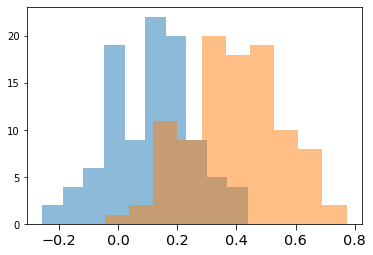

In [34]:
plt.hist(time_series1, alpha=0.5)
plt.hist(time_series2, alpha=0.5)

In [35]:
# Increase the values of these elements (multiply by 1.5)
num_events = 20
largest_indices = np.argpartition(time_series2, -num_events)[-num_events:]

# time_series3 = time_series2.copy()
time_series4 = time_series2.copy()
time_series5 = time_series2.copy()

time_series4[largest_indices] += 0.1
time_series5[largest_indices] += 0.4#0.35

# time_series3[largest_indices] += 0.1
# time_series4[largest_indices] += 0.35
# time_series5[largest_indices] += 0.45

In [36]:
ts1_mean = np.mean(time_series1)
ts1_mean

0.11151515151515155

In [37]:
fulltime_series3 = np.concatenate([time_series1, time_series2]) - ts1_mean
fulltime_series4 = np.concatenate([time_series1, time_series4]) - ts1_mean
fulltime_series5 = np.concatenate([time_series1, time_series5]) - ts1_mean

In [38]:
x = np.arange(len(fulltime_series3))

In [39]:
t3_polyfit = fit_series(x, fulltime_series3)
t4_polyfit = fit_series(x, fulltime_series4)
t5_polyfit = fit_series(x, fulltime_series5)

In [49]:
import pandas as pd

In [74]:
mock_time = pd.date_range(start='1900-01-01', freq='Y', periods=len(fulltime_series3))

detrened_df_3 = pd.DataFrame({'time': mock_time, 'data':fulltime_series3-t3_polyfit}).set_index('time')
detrened_df_4 = pd.DataFrame({'time': mock_time, 'data':fulltime_series4-t4_polyfit}).set_index('time')
detrened_df_5 = pd.DataFrame({'time': mock_time, 'data':fulltime_series5-t5_polyfit}).set_index('time')

rolling_noise3 = detrened_df_3.rolling(window=20, min_periods=5).std()
rolling_noise4 = detrened_df_4.rolling(window=20, min_periods=5).std()
rolling_noise5 = detrened_df_5.rolling(window=20, min_periods=5).std()


rolling_noise3['sn'] = fulltime_series3/rolling_noise3['data']
rolling_noise4['sn'] = fulltime_series4/rolling_noise4['data']
rolling_noise5['sn'] = fulltime_series5/rolling_noise5['data']


rolling_noise3 = rolling_noise3.iloc[10:-10, :]
rolling_noise4 = rolling_noise4.iloc[10:-10, :]
rolling_noise5 = rolling_noise5.iloc[10:-10, :]

<AxesSubplot:xlabel='time'>

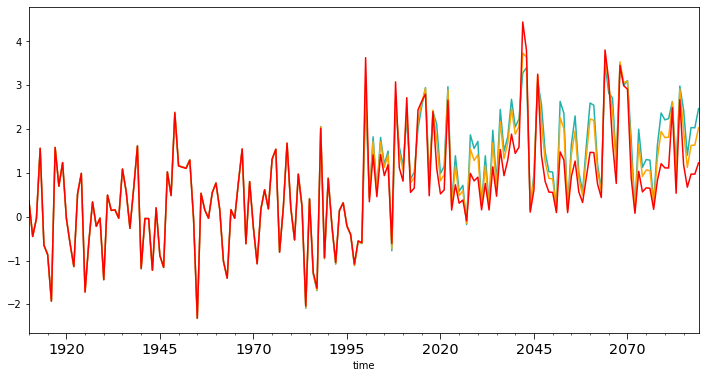

In [75]:
fig = plt.figure(figsize=(12, 6))
rolling_noise3['sn'].plot(color='lightseagreen')
rolling_noise4['sn'].plot(color='orange')
rolling_noise5['sn'].plot(color='red')

In [61]:
sn3 = t3_polyfit/np.std(fulltime_series3-t3_polyfit)
sn4 = t4_polyfit/np.std(fulltime_series4-t4_polyfit)
sn5 = t5_polyfit/np.std(fulltime_series5-t5_polyfit)

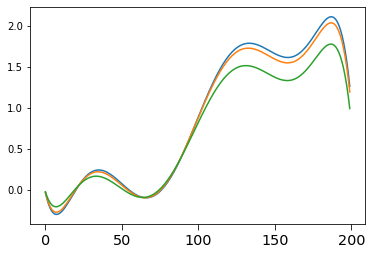

In [41]:
plt.plot(sn3)
plt.plot(sn4)
plt.plot(sn5)

In [42]:
fulltime_series3_pval = stats_test_1d_array(fulltime_series3, return_ks_pvalue)
fulltime_series4_pval = stats_test_1d_array(fulltime_series4, return_ks_pvalue)
fulltime_series5_pval = stats_test_1d_array(fulltime_series5, return_ks_pvalue)

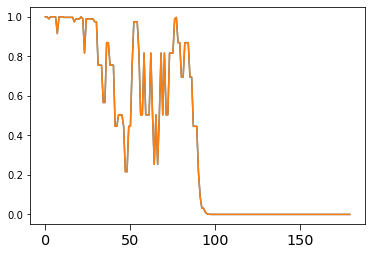

In [43]:
plt.plot(fulltime_series3_pval)
plt.plot(fulltime_series4_pval)
# plt.plot(fulltime_series5_pval)

In [44]:
# # t1_polyfit =np.polyval(np.polyfit(x, time_series1, deg=4), x)
# t2_polyfit = fit_two_series(time_series1, time_series2)
# t3_polyfit = fit_two_series(time_series1, time_series3)
# t4_polyfit = fit_two_series(time_series1, time_series4)
x = np.arange(len(fulltime_series3))

t3_polyfit = fit_series(x, fulltime_series3)
t4_polyfit = fit_series(x , fulltime_series4)
t5_polyfit = fit_series(x, fulltime_series5)

# t4_polyfit = fit_two_series(time_series1, time_series2)

In [45]:
sn3 = t3_polyfit/np.std(fulltime_series3-t3_polyfit)
sn4 = t4_polyfit/np.std(fulltime_series4-t4_polyfit)
sn5 = t5_polyfit/np.std(fulltime_series5-t5_polyfit)

In [46]:
# sn2 = t2_polyfit/np.std(np.concatenate([time_series1, time_series2])-t2_polyfit)
# sn3 = t3_polyfit/np.std(np.concatenate([time_series1, time_series3])-t3_polyfit)
# sn4 = t4_polyfit/np.std(np.concatenate([time_series1, time_series4])-t4_polyfit)

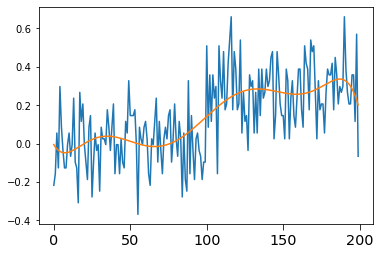

In [47]:
plt.plot(fulltime_series3)
plt.plot(t3_polyfit)

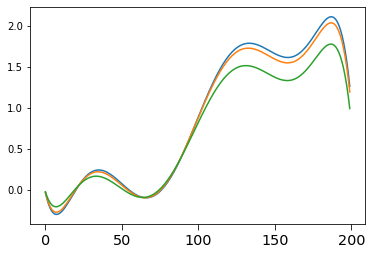

In [48]:
plt.plot(sn3)
plt.plot(sn4)
plt.plot(sn5)

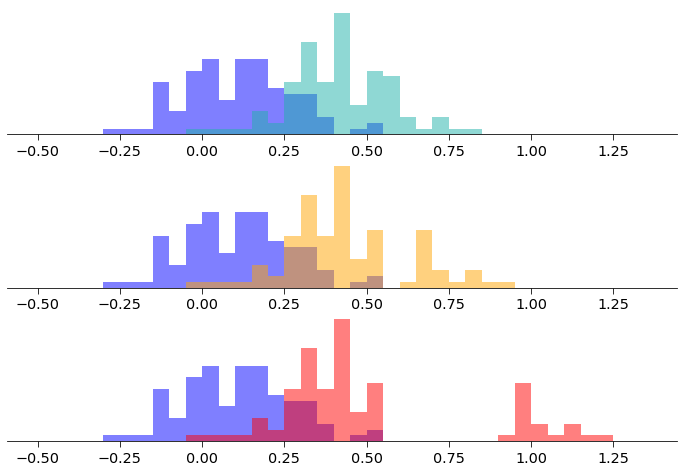

In [408]:
fig = plt.figure(figsize=(12, 8))

axes = [fig.add_subplot(3, 1, i+1) for i in range(3)]

bins = np.arange(-.5, 1.4, .05)

# axes[0].hist(time_series1, alpha=0.5,bins=bins)
# plt.hist(time_series2, alpha=0.5)
# plt.hist(time_series3, alpha=0.5)

axes[0].hist(time_series1, alpha=0.5,bins=bins, color='blue')
axes[0].hist(time_series2, alpha=0.5,bins=bins, color='lightseagreen')

axes[1].hist(time_series1, alpha=0.5,bins=bins, color='blue');
axes[1].hist(time_series4, alpha=0.5,bins=bins, color='orange');

axes[2].hist(time_series1, alpha=0.5,bins=bins, color='blue');
axes[2].hist(time_series5, alpha=0.5,bins=bins, color='red');

for ax in axes:
    [ax.spines[spine].set_visible(False) for spine in ['top', 'left', 'right']]
    ax.set_yticklabels([])
    ax.set_yticks([])



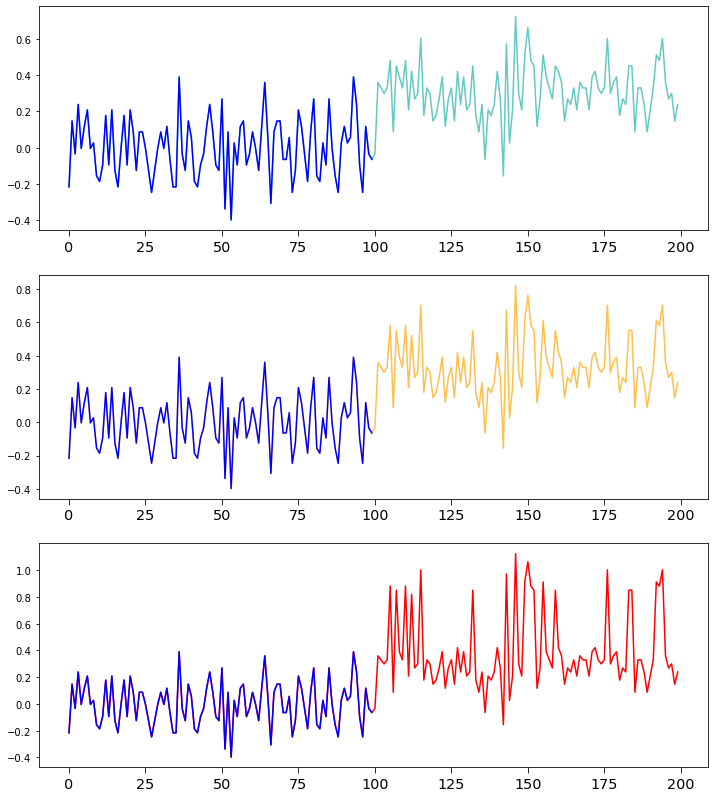

In [406]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 14))


ax1.plot(x, fulltime_series3, color='lightseagreen', alpha=0.7)
ax1.plot(time_series1 - ts1_mean, alpha=1, color='blue')

ax2.plot(x, fulltime_series4, color='orange', alpha=0.7)
ax2.plot(time_series1 - ts1_mean, alpha=1, color='blue')

ax3.plot(x, fulltime_series5, color='red')
ax3.plot(time_series1 - ts1_mean, alpha=1, color='blue')



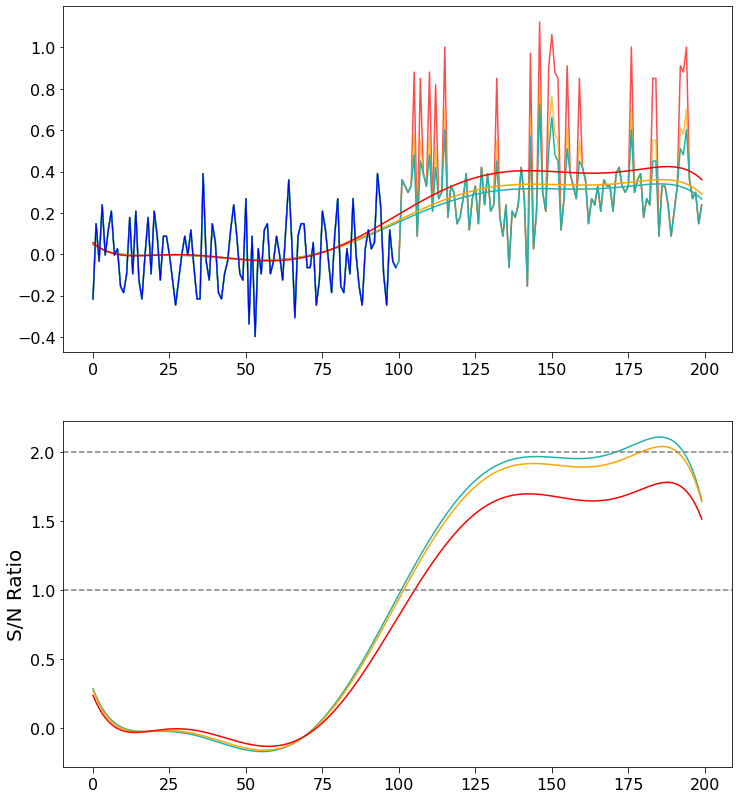

In [415]:
# Plot the time series
fig, (ax, ax2) = plt.subplots(2, 1,figsize=(12, 14))

ax.plot(x, fulltime_series5, color='red', alpha=0.7)
ax.plot(x, fulltime_series4, color='orange', alpha=0.7)
ax.plot(x, fulltime_series3, color='lightseagreen')


ax.plot(np.arange(len(time_series1)), time_series1 - ts1_mean, color='lightseagreen')


ax.plot(t3_polyfit, color='lightseagreen')
ax.plot(t4_polyfit, color='orange')
ax.plot(t5_polyfit, color='red')


ax2.plot(sn3, color='lightseagreen')
ax2.plot(sn4, color='orange')
ax2.plot(sn5, color='red')
ax2.axhline(1, c='grey', linestyle='--')
ax2.axhline(2, c='grey', linestyle='--')


ax.plot(time_series1 - ts1_mean, alpha=1, linewidth=1.1, color='blue')
ax2.set_ylabel('S/N Ratio', size=20)
ax2.set_ylabel('S/N Ratio', size=20)



for axs in [ax, ax2]:
    axs.tick_params(axis='y', labelsize=16)
    axs.tick_params(axis='x', labelsize=16)

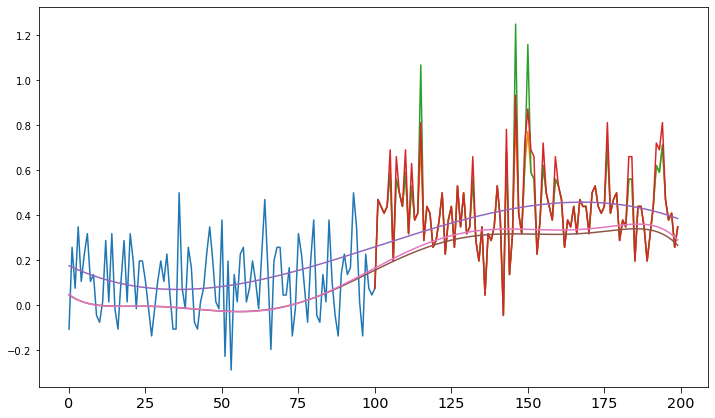

In [402]:
# Plot the time series
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(np.arange(len(time_series1)+1), time_series1.tolist()+ time_series2[:1].tolist())
ax.plot(np.arange(len(time_series1), len(time_series1)+len(time_series2)), time_series2)
ax.plot(np.arange(len(time_series1), len(time_series1)+len(time_series2)), time_series3)
ax.plot(np.arange(len(time_series1), len(time_series1)+len(time_series2)), time_series4)

ax.plot(t2_polyfit)
ax.plot(t3_polyfit)
ax.plot(t4_polyfit)

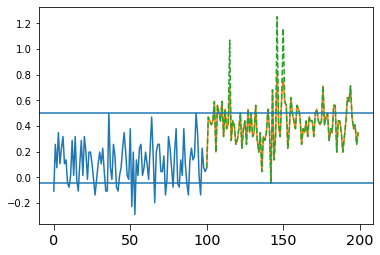

In [337]:
# Plot the time series
fig, ax = plt.subplots()
ax.plot(np.arange(len(time_series1)+1), time_series1.tolist()+ time_series2[:1].tolist())
ax.plot(np.arange(len(time_series1), len(time_series1)+len(time_series2)), time_series2)
ax.plot(np.arange(len(time_series1), len(time_series1)+len(time_series2)), time_series3, linestyle='--')


ax.axhline(np.max(time_series1))
ax.axhline(np.min(time_series2))

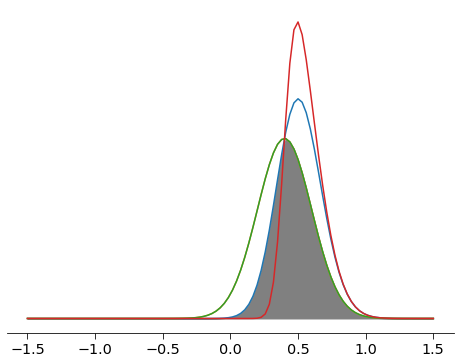

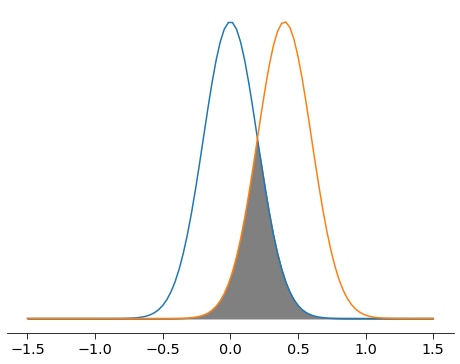

In [113]:
fig,ax = plt.subplots(figsize=(8, 6))
ax.plot(x2,dist1)
ax.plot(x2,dist2)
ax.fill_between(x2, [0] * len(overlap), overlap, color='grey')

# Remove all spoines but x-axis
[ax.spines[spine].set_visible(False) for spine in ['top', 'left', 'right']]

ax.set_yticks([]);

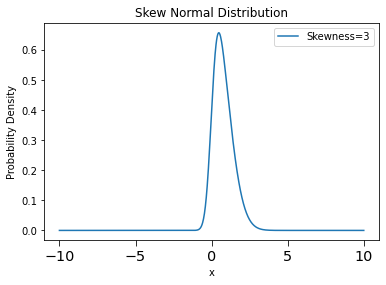

In [97]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

def skew_gaussian(x, mean, std, skewness):
    # Adjust the skewness parameter for the skew normal distribution
    return stats.skewnorm.pdf(x, skewness, loc=mean, scale=std)

# Example usage
mean = 0
std = 1
skewness = 3# Positive for right skew, negative for left skew

x = np.linspace(-10, 10, 1000)
y = skew_gaussian(x, mean, std, skewness)

plt.plot(x, y, label=f'Skewness={skewness}')
plt.legend()
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title('Skew Normal Distribution')
plt.show()


In [94]:
def adjust_scale_for_variance(std, skewness):
    delta = skewness / np.sqrt(1 + skewness ** 2)
    adjusted_std = std / np.sqrt(1 - (2 * delta ** 2) / np.pi)
    return adjusted_std

# Example usage with variance adjustment
mean = 0
std = 1
skewness = 5

adjusted_std = adjust_scale_for_variance(std, skewness)

x = np.linspace(-10, 10, 1000)
y = skew_gaussian(x, mean, adjusted_std, skewness)

plt.plot(x, y, label=f'Skewness={skewness}')
plt.legend()
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title('Skew Normal Distribution with Adjusted Variance')
plt.show()


NameError: name 'skew_gaussian' is not defined

# KS Samples with no Signal

In [18]:
from scipy.stats import ks_2samp

In [85]:
kde3 = gaussian(x2, 0, 0.5)
kde4 = gaussian(x2, 0, 1)

In [86]:
ks_2samp(kde3, kde4)

KstestResult(statistic=0.49656, pvalue=0.0)

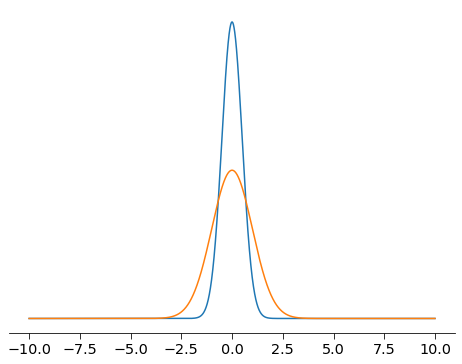

In [87]:
fig,ax = plt.subplots(figsize=(8, 6))

ax.plot(x2, kde3)
ax.plot(x2, kde4)
# Remove all spoines but x-axis
[ax.spines[spine].set_visible(False) for spine in ['top', 'left', 'right']]

ax.set_yticks([]);

In [78]:
from scipy.special import erf
def add_kurtosis(data, kurtosis):
    # Calculate the excess kurtosis (kurtosis - 3)
    excess_kurt = kurtosis - 3
    
    # Calculate the Cornish-Fisher expansion coefficients
    c0 = 1
    c1 = 0
    c2 = excess_kurt / 2
    c3 = 0
    c4 = -excess_kurt / 3
    
    # Apply the transformation to the data
    transformed_data = (
        data
        + (c2 * (data ** 2 - 1) + c4 * (data ** 3 - 3 * data)) * erf(data / np.sqrt(2))
        + c1 * (data ** 3 - 3 * data) / np.sqrt(2)
        + c3 * (data ** 4 - 6 * data ** 2 + 3) / (2 * np.sqrt(2))
    )
    
    return transformed_data

# Generate data from the Gaussian function
mean = 0
std = 1
data = gaussian(x2, mean, std)

# Add kurtosis to the data
kurtosis = 5  # Desired kurtosis value
transformed_data = add_kurtosis(data, kurtosis)

In [79]:
transformed_data = transformed_data/np.sum(transformed_data)
data = data/np.sum(data)

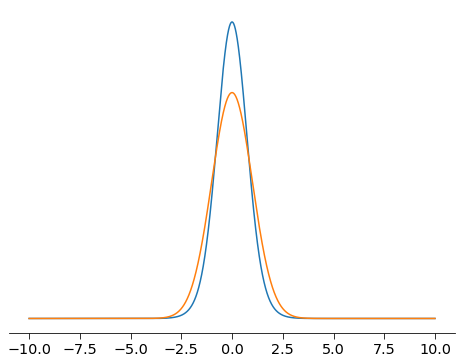

In [88]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(x2, transformed_data)
ax.plot(x2, data)

# Remove all spoines but x-axis
[ax.spines[spine].set_visible(False) for spine in ['top', 'left', 'right']]

ax.set_yticks([]);